In [1]:
import numpy as np
import pandas as pd
from cardiotox import build_model,plotea
from build import building
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import random
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler,MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import GridSearchCV,KFold,train_test_split, cross_val_score
from sklearn.metrics import accuracy_score,r2_score,mean_squared_error,mean_absolute_error
import matplotlib.pyplot as plt
import time
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows',15)


df=building('KrKsCaL.xlsx').dataframe()
df.head()

,Kr,Ks,CaL,APD90
0,-3.0,-3.0,0.6,232.33
1,-3.0,-2.9,0.6,232.33
2,-3.0,-2.8,0.6,232.34
3,-3.0,-2.7,0.6,232.34
4,-3.0,-3.0,0.5,232.35


In [2]:
original=df.copy()

Data points with an $APD_{90}$ shorter than the $1^{st}$ quartile plus 1.5 times the interquartile range (IQR) or larger than the $3^{rd}$ quartile plus 1.5 times the IQR were considered outliers and removed according to IQR rule.

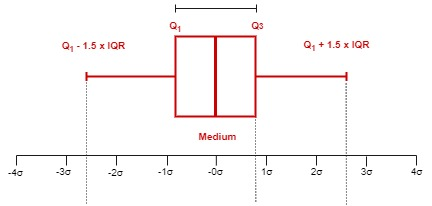

<h4 align="center">Figure 1. IQR rule</h4> 

In [3]:
Q1 = original[['APD90']].quantile(0.25)
Q3 = original[['APD90']].quantile(0.75)
IQR = Q3 - Q1

df2 = original[['APD90']][~((original[['APD90']] < (Q1 - 1.5 * IQR)) |(original[['APD90']] > (Q3 + 1.5 * IQR))).any(axis=1)]

In [4]:
borrados=original.loc[~(original.index.isin(df2.index))]

This filter removed **1.4% of the data points**, with **values** ranging between **777.59 and 865.47 ms**.

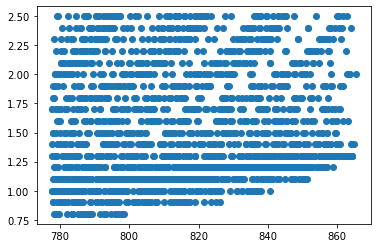

In [5]:
plt.scatter(borrados.APD90,borrados.Kr);

In [6]:
df=df[df.index.isin(df2.index)].reset_index(drop=True)

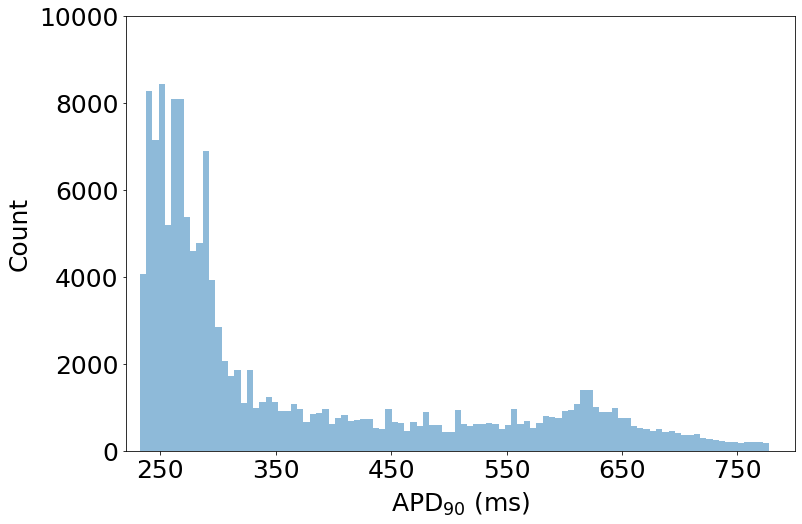

In [7]:
import seaborn as sns

def dist(df1):

    plt.figure(figsize=(12,8))
    plt.hist(df1.APD90,bins=100,alpha=0.5)
    params = {'mathtext.default': 'regular' }          
    plt.rcParams.update(params)
    plt.rcParams["font.family"] = 'Franklin Gothic Medium'
    plt.tick_params(axis='both', labelsize=25)
    plt.xlabel('$APD_{90}$ (ms)',fontsize=25,labelpad=8)
    plt.ylabel('Count',fontsize=25,labelpad=8)
    plt.xlim(220,800)
    plt.ylim(0,10000)
    plt.xticks([250,350,450,550,650,750])
    plt.show()
dist(df)

Split the dataset in **three partitions: train (1%), validation (1%) and test sets (98%)**. 

In [8]:
X_train,X_test,X_val,y_train,y_test,y_val=building('KrKsCaL.xlsx').split(n=100,df=df)

In [9]:
with open("modelo_svr_1_100_train_test_new_partition.pkl", "rb") as f:
    opciones = pickle.load(f)
model_svr=opciones["modelo"]

MAE selecting 1/100 indexes for training series 0.542
MAE selecting 1/100 indexes for Validation series 0.830
MAE selecting 1/100 indexes for test series 0.811
MRE train set=0.15%
MRE validation set=0.21%
MRE test set=0.21%
Maximum RE train set=1.37%
Maximum RE validation set=1.92%
Maximum RE test set=2.42%
When RE is between 0-5% a 100.00% of data have a RE lower than 5% for the train set
When RE is between 0-5% a 100.00% of data have a RE lower than 5% for the validation set
When RE is between 0-5% a 100.00% of data have a RE lower than 5% for the test set


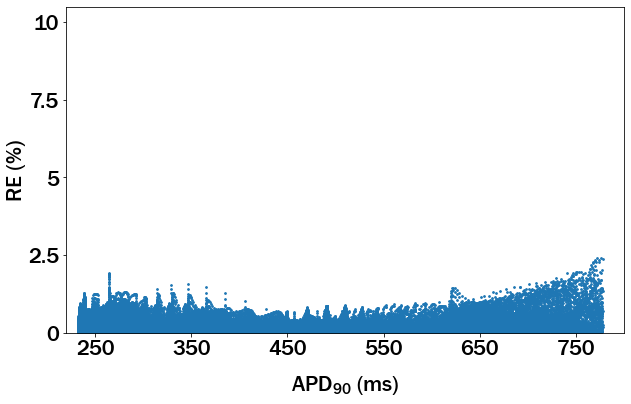

In [10]:
build_model(model_svr,n2=100,c=300000,n_error_min=0,n_error_max=5,X_train=X_train,X_val=X_val,X_test=X_test,y_train=y_train,y_val=y_val,y_test=y_test)

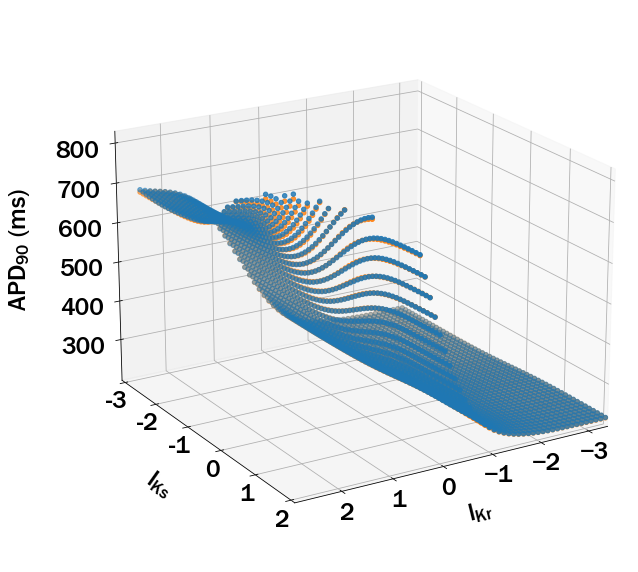

In [22]:
plotea(model_svr,n_ical=0.3,X_train=X_train, X_val=X_val,X_test=X_test, y_train=y_train, y_val=y_val,y_test=y_test)
plt.show()

### We load the data with CIPA information for external validation

In [12]:
external_val=pd.read_excel(r"C:\Users\parod\Downloads\APD90_12CiPA_drugs_IKrIKsICaL.xlsx",engine='openpyxl')[['Name', 'Kr',  'Ks','CaL', 'APD90']]
df_pol_test=pd.read_excel(r"C:\Users\parod\Downloads\EFTPC_IC50_28_CiPADrugs.xlsx",engine='openpyxl').iloc[1:13,:]
df_pol_test.loc[10,'Ks']=5000000
df_pol_test.loc[10,'Unnamed: 9']=1

In [13]:
df_pol_test['Kr']=df_pol_test['Kr'].astype('float')
df_pol_test['Unnamed: 3']=df_pol_test['Unnamed: 3'].astype('float')
df_pol_test['CaL']=df_pol_test['CaL'].astype('float')
df_pol_test['Unnamed: 5']=df_pol_test['Unnamed: 5'].astype('float')
df_pol_test['Ks']=df_pol_test['Ks'].astype('float')
df_pol_test['Unnamed: 9']=df_pol_test['Unnamed: 9'].astype('float')

The next equation is applied for each ion channel for recalculating input values of the test set:

Input value $=\log _{10}\left(\left[\frac{D}{I C_{50}}\right]^{h}\right)$

In [14]:
kr=np.clip(np.log10((df_pol_test.iloc[:,1]/df_pol_test.iloc[:,2])**df_pol_test.iloc[:,3]),-3,1)
ks=np.clip(np.log10((df_pol_test.iloc[:,1]/df_pol_test.iloc[:,8])**df_pol_test.iloc[:,9]),-3,1)
cal=np.clip(np.log10((df_pol_test.iloc[:,1]/df_pol_test.iloc[:,4])**df_pol_test.iloc[:,3]),-3,1)
arr=np.transpose(np.vstack([kr,ks,cal]))

In [15]:
df_external_val=pd.DataFrame(arr,columns=['Kr','Ks','CaL'])
df_external_val['Simulated_APD90']=external_val.APD90

In [16]:
df_external_val['SVM']=model_svr.predict(df_external_val.iloc[:,:3])

In [17]:
df_external_val.set_index(df_pol_test.Name,inplace=True)

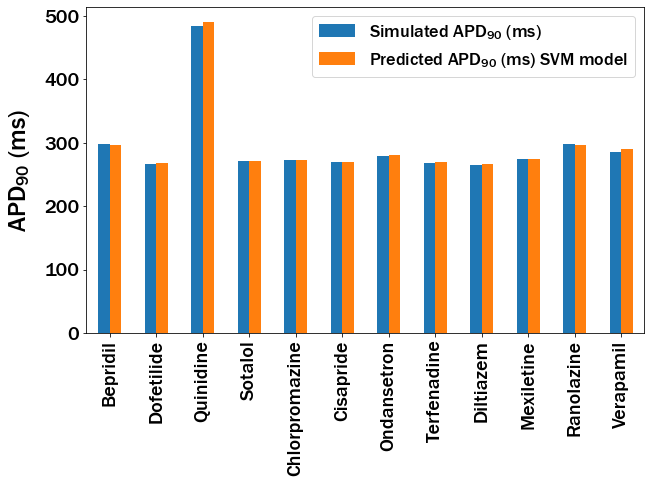

In [18]:
df_external_val.iloc[:,-2:].plot.bar(figsize=(10,6))
params = {'mathtext.default': 'regular' }              
plt.rcParams.update(params)
plt.rcParams["font.family"] = 'Franklin Gothic Medium'
plt.rcParams.update({'font.size': 25})
plt.tick_params(axis='both', labelsize=20)
plt.ylabel('$APD_{90}$ (ms)',fontsize=25,labelpad=12)
plt.xlabel('')
plt.legend(['Simulated $APD_{90}$ (ms)','Predicted $APD_{90}$ (ms) SVM model'],fontsize=18)
# plt.ylabel('Density',fontsize=15,labelpad=8)
# plt.xticks(np.arange(200,900,100))
plt.show()

In [19]:
def residuals(y2,y1):
    return (abs(y2-y1))*100/y1
df_external_val['RE(%) SVM']=residuals(df_external_val['SVM'],df_external_val['Simulated_APD90'])

In [20]:
df_external_val.iloc[:,-3:]

,Simulated_APD90,SVM,RE(%) SVM
Name,,,
Bepridil,298.880128,296.440332,0.816313
Dofetilide,267.290894,268.277051,0.368945
Quinidine,483.755978,490.028645,1.296659
Sotalol,271.351299,271.929595,0.213117
Chlorpromazine,273.088861,272.955050,0.048999
Cisapride,269.544016,269.652456,0.040231
Ondansetron,279.788175,281.154148,0.488217
Terfenadine,268.307656,269.078737,0.287387
Diltiazem,265.871037,266.744577,0.328558


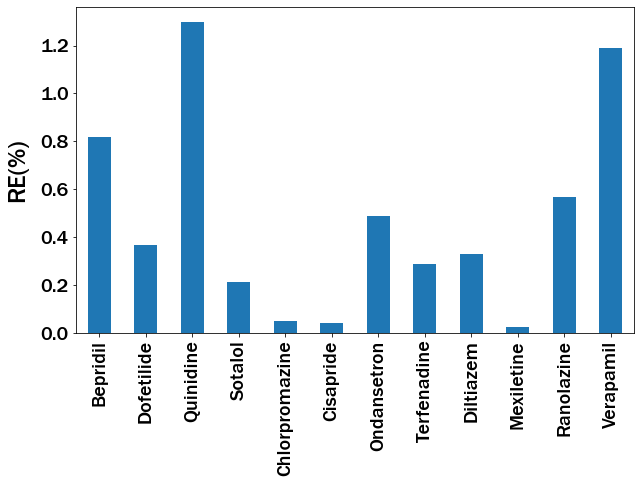

In [21]:
df_external_val.iloc[:,-1].plot.bar(figsize=(10,6))
params = {'mathtext.default': 'regular' }              
plt.rcParams.update(params)
plt.rcParams["font.family"] = 'Franklin Gothic Medium'
plt.rcParams.update({'font.size': 25})
plt.tick_params(axis='both', labelsize=20)
plt.ylabel('RE(%)',fontsize=25,labelpad=12)
plt.xlabel('')
plt.legend('',fontsize=20).remove()
# plt.ylabel('Density',fontsize=15,labelpad=8)
# plt.xticks(np.arange(200,900,100))
plt.show()